<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Symbol - Neural network graphs

In the [previous tutorial](http://mxnet.io/tutorials/basic/ndarray.html), we introduced [`NDArray`](https://mxnet.incubator.apache.org/api/python/ndarray/ndarray.html), the basic data structure for manipulating data in MXNet.
Just using `NDArray` by itself, we can execute a wide range of mathematical operations. In fact, we could define and update a full neural network just by using `NDArray`.

`NDArray` allows you to write programs for scientific computation in an imperative fashion, making full use of the native control of any front-end language. Gluon API uses this approach under the hood (before hybridization) to allow for flexible and debugable networks. So you might wonder, why don't we just use `NDArray` for all computation?

MXNet also provides the `Symbol API`, an interface for symbolic programming. With symbolic programming, rather than executing operations step by step, we first define a [computation graph](https://mxnet.incubator.apache.org/versions/master/faq/visualize_graph.html). This graph contains placeholders for inputs and designated outputs. We can then compile the graph, yielding a function that can be bound to `NDArray`s and run. MXNet's `Symbol API` is similar to the network configurations used by [Caffe](http://caffe.berkeleyvision.org/) and the symbolic programming in [Theano](http://deeplearning.net/software/theano/). Gluon API takes advantage of this approach under the hood after the network has been hybridized.

Another advantage conferred by symbolic approach is that we can optimize our functions before using them. For example, when we execute mathematical computations in imperative fashion, we don't know at the time that we run each operation, which values will be needed later on. But with symbolic programming, we declare the required outputs in advance. This means that we can recycle memory allocated in intermediate steps, as by performing operations in place. Symbolic API also uses less memory for the
same network. Refer to [How To](http://mxnet.io/faq/index.html) and [Architecture](http://mxnet.io/architecture/index.html) section to know more.

In our design notes, we present [a more thorough discussion on the comparative strengths of imperative and symbolic programing](http://mxnet.io/architecture/program_model.html). In this document, however, we'll focus on explaining how to use MXNet's `Symbol API`.

In MXNet, we can compose Symbols from other Symbols, using operators, such as simple matrix operations (e.g. `+`), or whole neural network layers (e.g. convolution layer). Operator can take multiple input variables, can produce multiple output symbols and can maintain internal state symbols. For a visual explanation of these concepts, see [Symbolic Configuration and Execution in Pictures](http://mxnet.io/api/python/symbol_in_pictures/symbol_in_pictures.html).

To make things concrete, let's take a hands-on look at the `Symbol API`. There are a few different ways to compose a [`Symbol`](http://mxnet.incubator.apache.org/api/python/symbol/symbol.html).

## Prerequisites

To complete this tutorial, we need:

- MXNet. See the instructions for your operating system in [Setup and Installation](http://mxnet.io/install/index.html)
- [Jupyter](http://jupyter.org/)
    ```
    pip install jupyter
    ```
- GPUs (optional). A section of this tutorial uses GPUs, if one is available. If not, the code will automatically switch to CPU.

## Basic Symbol Composition

### Basic Operators

The following example builds a simple expression: `a + b`. First, we create two placeholders with `mx.sym.Variable`,
giving them the names `a` and `b`. We then construct the desired symbol by using the operator `+`. We don't need to name our variables while creating them, MXNet will automatically generate a unique name for each. In the example below, `c` is assigned a unique name automatically.

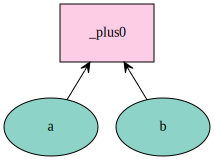

In [2]:
import mxnet as mx
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
c = a + b
(a, b, c)
mx.viz.plot_network(c)

Most operators supported by `NDArray` are also supported by `Symbol`, for example:

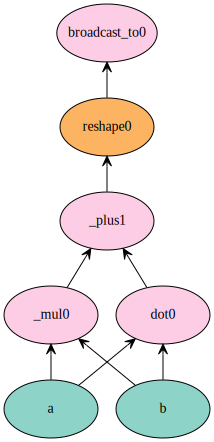

In [3]:
# element-wise multiplication
d = a * b
# matrix multiplication
e = mx.sym.dot(a, b)
# reshape
f = mx.sym.reshape(d+e, shape=(1,4))
# broadcast
g = mx.sym.broadcast_to(f, shape=(2,4))
# plot
mx.viz.plot_network(symbol=g,
                    node_attrs={"shape": "oval", "fixedsize": "false"})

The computations declared in the above examples can be bound to the input data for evaluation by using `bind` method. We discuss this further in the [Symbol Manipulation](#symbol-manipulation) section.

### Basic Neural Networks

Besides the basic operators, `Symbol` also supports a rich set of neural network layers.
The following example constructs a two layer fully connected neural network
and then visualizes the structure of that network given the input data shape.

In [161]:
net=mx.sym.Variable('data')

net=mx.sym.Convolution(net,num_filter=12,kernel=(5,5),stride=(1,1),name='conv1')
net=mx.sym.Activation(net,'relu')
net=mx.sym.Pooling(net,stride=(2,2),kernel=(3,3),pool_type='max')


net=mx.sym.Convolution(net,num_filter=36,kernel=(3,3),stride=(1,1),name='conv2')
net=mx.sym.Activation(net,'relu')
net=mx.sym.Pooling(net,stride=(2,2),kernel=(3,3),pool_type='max')

net=mx.sym.FullyConnected(net,num_hidden=128,name='fc1')
fc2=mx.sym.FullyConnected(net,num_hidden=10,name='fc2')
net=mx.sym.SoftmaxOutput(fc2,name='myout')
# mx.viz.plot_network(net,
#                     shape={'data':(1,3,28,28)},
#                     node_attrs={"shape": "oval", "fixedsize": "false"}
#                    )
net.list_arguments()

['data',
 'conv1_weight',
 'conv1_bias',
 'conv2_weight',
 'conv2_bias',
 'fc1_weight',
 'fc1_bias',
 'fc2_weight',
 'fc2_bias',
 'myout_label']

In [160]:
##假设我要提取一个图片的特征,报错的原因是 不光要给出输入，神经网络的所有参数都要给
X=mx.nd.random.uniform(-1,1,shape=(32,1,28,28))
ex=fc2.bind(ctx=mx.cpu(),args={'data':X})
out=ex.forward()

ValueError: key `conv1_weight` is missing in `args`

In [124]:
##使用simple_bind就会字段创建变量
X=mx.nd.random.uniform(-1,1,shape=(32,1,28,28))
ex=fc2.simple_bind(ctx=mx.cpu(),data=(32,1,28,28),grad_req='null')
out=ex.forward(False,data=X)
# out[0].asnumpy()
# ex.arg_arrays

[
 [[[[ 0.69630075 -0.89498365  0.87166417 ... -0.8068742  -0.66194916
      0.96986663]
    [ 0.7191616   0.79316247 -0.88293016 ... -0.75231117 -0.31056374
      0.7135105 ]
    [ 0.42753375 -0.20066524  0.27837384 ...  0.13710845 -0.47690088
      0.21288359]
    ...
    [ 0.6199442  -0.47336912  0.6095458  ... -0.34200084 -0.6593443
     -0.42797524]
    [-0.41145414  0.23743677  0.79192305 ... -0.8633542  -0.42676258
     -0.41481584]
    [-0.5107957   0.25488818  0.64261866 ... -0.06767911  0.27274096
      0.5160016 ]]]
 
 
  [[[ 0.75994015 -0.04824042  0.17390883 ... -0.6222601  -0.78107905
      0.2089845 ]
    [-0.09266192  0.64204085  0.22414672 ...  0.24132788  0.31928217
     -0.20270061]
    [-0.44691855  0.35155344  0.3658179  ... -0.16626608 -0.74561745
      0.8422862 ]
    ...
    [ 0.9470278  -0.2285642   0.614344   ... -0.38765383 -0.22872853
     -0.29198664]
    [-0.07673442 -0.99498487 -0.34077865 ...  0.15067232  0.7649764
      0.30045342]
    [ 0.47366405 -0.3

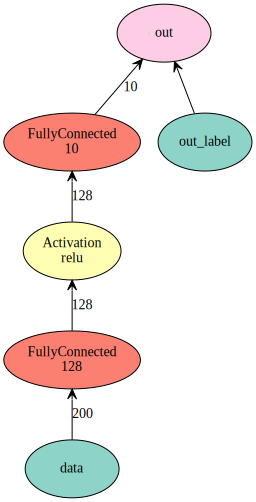

In [9]:
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=net, name='relu1', act_type="relu")
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=10)
net = mx.sym.SoftmaxOutput(data=net, name='out')
mx.viz.plot_network(net,
                    shape={'data':(100, 200)},
                    node_attrs={"shape": "oval", "fixedsize": "false"}
                   )

Each `Symbol` takes a unique string name. `NDArray` and `Symbol` both represent a single tensor. *Operators* represent the computation between tensors. Operators take `Symbol` or `NDArray` as inputs and might also additionally accept other hyperparameters such as the number of hidden neurons (`num_hidden`) or the activation type (`act_type`) and produce the output.

We can view a `Symbol` simply as a function taking several arguments. And we can retrieve those arguments with the following method call:

In [10]:
net.list_arguments()

['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias', 'out_label']

These arguments are the parameters and inputs needed by each `Symbol`:

- *data*: Input data needed by the variable *data*.
- *fc1_weight* and *fc1_bias*: The weight and bias for the first fully connected layer *fc1*.
- *fc2_weight* and *fc2_bias*: The weight and bias for the second fully connected layer *fc2*.
- *out_label*: The label needed by the loss.

We can also specify the names explicitly:

In [13]:
net = mx.symbol.Variable('data')
w = mx.symbol.Variable('myweight')
net = mx.symbol.FullyConnected(data=net, weight=w, name='fc1', num_hidden=128)
net.list_arguments()

['data', 'myweight', 'fc1_bias']

In [14]:
conv=mx.symbol.Convolution(name='cv1',num_filter=32,kernel=(3,3),stride=(2,2))
conv.list_arguments()

['cv1_data', 'cv1_weight', 'cv1_bias']

### 练习 Parameter relu

In [17]:
indata=mx.symbol.Variable(name='my',shape=(100,3,32,32))
ac=mx.symbol.LeakyReLU(data=indata,act_type='prelu')
ac.list_arguments()
# mx.viz.plot_network(ac,node_attrs={'shape':'oval'},shape={'my':(100,3,32,32)})

['my', 'leakyrelu0_gamma']

In the above example, `FullyConnected` layer has 3 inputs: data, weight, bias. When any input is not specified, a variable will be automatically generated for it.

## More Complicated Composition

MXNet provides well-optimized Symbols for layers commonly used in deep learning (see [src/operator](https://github.com/dmlc/mxnet/tree/master/src/operator)). We can also define new operators in Python. The following example first
performs an element-wise add between two Symbols, then feeds them to the fully connected operator:

In [18]:
lhs = mx.symbol.Variable('data1')
rhs = mx.symbol.Variable('data2')
net = mx.symbol.FullyConnected(data=lhs + rhs, name='fc1', num_hidden=128)
net.list_arguments()
# mx.viz.plot_network(net,node_attrs={'shape':'oval'})

['data1', 'data2', 'fc1_weight', 'fc1_bias']

We can also construct a `Symbol` in a more flexible way than the single forward composition depicted in the preceding example:

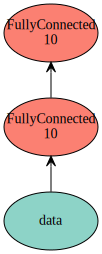

In [10]:
data = mx.symbol.Variable('data')
net1 = mx.symbol.FullyConnected(data=data, name='fc1', num_hidden=10)
net1.list_arguments()
net2 = mx.symbol.Variable('data2')
net2 = mx.symbol.FullyConnected(data=net2, name='fc2', num_hidden=10)
composed = net2(data2=net1, name='composed')
composed.list_arguments()
mx.viz.plot_network(composed,node_attrs={'shape':'oval'})

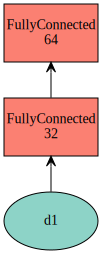

In [22]:
#合成操作，假设有2个不 相关  的网络
netA=mx.sym.Variable('d1')
netA=mx.sym.FullyConnected(data=netA,num_hidden=32)

netB=mx.sym.Variable('d2')
netB=mx.sym.FullyConnected(data=netB,num_hidden=64)

C=netB(d2=netA,name='compose')
mx.viz.plot_network(C)

In this example, `net2` is used as a function to apply to an existing `Symbol` `net1`, and the resulting *composed* `Symbol` will have all the attributes of `net1` and `net2`.

Once you start building some bigger networks, you might want to name some symbols with a common prefix to outline the structure of your network. You can use the [Prefix class](https://github.com/apache/incubator-mxnet/blob/master/python/mxnet/name.py#L93) as follows:

In [27]:
stages=[1,2,3]
net=mx.sym.Variable('input')
for s in stages:
    with mx.name.Prefix('stage%d_'%(s)):
        net=mx.sym.Convolution(net,kernel=(3,3),stride=(2,2),num_filter=(s)*32)
        net=mx.sym.Activation(net,act_type='relu')
        net=mx.sym.BatchNorm(net)
net.list_arguments()

['input',
 'stage1_convolution0_weight',
 'stage1_convolution0_bias',
 'stage1_batchnorm0_gamma',
 'stage1_batchnorm0_beta',
 'stage2_convolution0_weight',
 'stage2_convolution0_bias',
 'stage2_batchnorm0_gamma',
 'stage2_batchnorm0_beta',
 'stage3_convolution0_weight',
 'stage3_convolution0_bias',
 'stage3_batchnorm0_gamma',
 'stage3_batchnorm0_beta']

In [28]:
data = mx.sym.Variable("data")
net = data
n_layer = 2
for i in range(n_layer):
    with mx.name.Prefix("layer%d_" % (i + 1)):
        net = mx.sym.FullyConnected(data=net, name="fc", num_hidden=100)
net.list_arguments()

['data',
 'layer1_fc_weight',
 'layer1_fc_bias',
 'layer2_fc_weight',
 'layer2_fc_bias']

### Modularized Construction for Deep Networks

Constructing a *deep* network layer by layer, (like the Google Inception network), can be tedious owing to the large number of layers. So, for such networks, we often modularize the construction.

For example, in Google Inception network, we can first define a factory function which chains the convolution, batch normalization and rectified linear unit (ReLU) activation layers together.

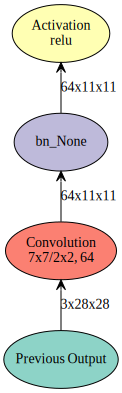

In [29]:
def ConvFactory(data, num_filter, kernel,
                stride=(1, 1), pad=(0, 0), name=None, suffix=''):
    conv = mx.sym.Convolution(data=data, num_filter=num_filter,
                              kernel=kernel, stride=stride, pad=pad,
                              name='conv_%s%s' % (name, suffix))

    bn = mx.sym.BatchNorm(data=conv, name='bn_%s%s' % (name, suffix))

    act = mx.sym.Activation(data=bn, act_type='relu',
                            name='relu_%s%s' % (name, suffix))
    return act

prev = mx.sym.Variable(name="Previous Output")
conv_comp = ConvFactory(data=prev, num_filter=64, kernel=(7, 7), stride=(2, 2))
shape = {"Previous Output" : (128, 3, 28, 28)}
mx.viz.plot_network(symbol=conv_comp, shape=shape,
                    node_attrs={"shape": "oval", "fixedsize": "false"})

Then we can define a function that constructs an inception module based on factory function `ConvFactory`.

In [30]:
def InceptionFactoryA(data, num_1x1, num_3x3red, num_3x3, num_d3x3red,
                      num_d3x3, pool, proj, name):
    # 1x1
    c1x1 = ConvFactory(data=data, num_filter=num_1x1, kernel=(1, 1),
                       name=('%s_1x1' % name))

    # 3x3 reduce + 3x3
    c3x3r = ConvFactory(data=data, num_filter=num_3x3red, kernel=(1, 1),
                        name=('%s_3x3' % name), suffix='_reduce')
    c3x3 = ConvFactory(data=c3x3r, num_filter=num_3x3, kernel=(3, 3),
                       pad=(1, 1), name=('%s_3x3' % name))

    # double 3x3 reduce + double 3x3
    cd3x3r = ConvFactory(data=data, num_filter=num_d3x3red, kernel=(1, 1),
                         name=('%s_double_3x3' % name), suffix='_reduce')
    cd3x3 = ConvFactory(data=cd3x3r, num_filter=num_d3x3, kernel=(3, 3),
                        pad=(1, 1), name=('%s_double_3x3_0' % name))
    cd3x3 = ConvFactory(data=cd3x3, num_filter=num_d3x3, kernel=(3, 3),
                        pad=(1, 1), name=('%s_double_3x3_1' % name))

    # pool + proj
    pooling = mx.sym.Pooling(data=data, kernel=(3, 3), stride=(1, 1),
                             pad=(1, 1), pool_type=pool,
                             name=('%s_pool_%s_pool' % (pool, name)))
    cproj = ConvFactory(data=pooling, num_filter=proj, kernel=(1, 1),
                        name=('%s_proj' %  name))

    # concat
    concat = mx.sym.Concat(*[c1x1, c3x3, cd3x3, cproj],
                           name='ch_concat_%s_chconcat' % name)
    return concat

prev = mx.sym.Variable(name="Previous Output")
in3a = InceptionFactoryA(prev, 64, 64, 64, 64, 96, "avg", 32, name="in3a")
# mx.viz.plot_network(symbol=in3a, shape=shape,
#                     node_attrs={"shape": "oval", "fixedsize": "false"})

### 模块化
##### 公共方法模块化

In [88]:
def convBase(data,filters,kernel,stride,pad):
    c=mx.sym.Convolution(data,num_filter=filters,kernel=kernel,stride=stride,pad=pad)
    a=mx.sym.Activation(c,act_type='relu')
    r=mx.sym.BatchNorm(a)
    return r
def inception(data,d1,d3,d3_reduce,d5,d5_reduce):
    with mx.name.Prefix('route1_'):
        route1=convBase(data,d1,kernel=(1,1),stride=(2,2),pad=(0,0))
    with mx.name.Prefix('route2_'):
        route2=convBase(data,d3_reduce,kernel=(1,1),stride=(2,2),pad=(0,0))
        route2=convBase(route2,d3_reduce,kernel=(3,3),stride=(1,1),pad=(1,1))
        route2=convBase(route2,d3,kernel=(1,1),stride=(1,1),pad=(0,0))
    with mx.name.Prefix('route3_'):
        route3=convBase(data,d5_reduce,kernel=(1,1),stride=(2,2),pad=(0,0))
        route3=convBase(route3,d5_reduce,kernel=(3,3),stride=(1,1),pad=(1,1))
        route3=convBase(route3,d5_reduce,kernel=(3,3),stride=(1,1),pad=(1,1))
        route3=convBase(route3,d5,kernel=(1,1),stride=(1,1),pad=(0,0))
    with mx.name.Prefix('route4_'):
        route4=mx.sym.Pooling(data,pool_type='max',kernel=(3,3),stride=(2,2),pad=(1,1))
    
    
    cat=mx.sym.Concat(*(route1,route2,route3,route4),dim=1)
    
    return cat
X=mx.sym.Variable('data')
mynet=inception(X,32,64,32,32,16)
# mx.viz.plot_network(mynet,shape={'data':(1,3,28,28)})
argname=mynet.list_arguments()
outname=mynet.list_outputs()
shape,outshape,_=mynet.infer_shape(data=(128,3,28,28))
dict(zip(argname,shape))
print(outshape)

[(128, 131, 14, 14)]


Finally, we can obtain the whole network by chaining multiple inception modules. See a complete example [here](https://github.com/dmlc/mxnet/blob/master/example/image-classification/symbols/inception-bn.py).

### Group Multiple Symbols

To construct neural networks with multiple loss layers, we can use `mxnet.sym.Group` to group multiple Symbols together. The following example groups two outputs:

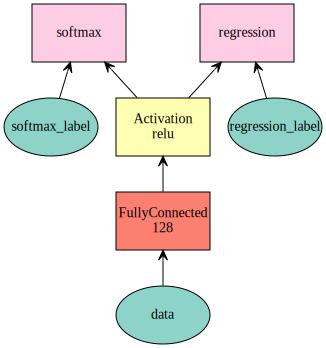

In [47]:
net = mx.sym.Variable('data')
fc1 = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")
out1 = mx.sym.SoftmaxOutput(data=net, name='softmax')
out2 = mx.sym.LinearRegressionOutput(data=net, name='regression')
group = mx.sym.Group([out1, out2])
group.list_outputs()
mx.viz.plot_network(group)

In [54]:
from mxnet.symbol import *

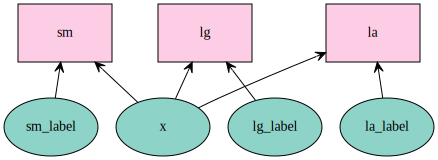

In [63]:
v=Variable('x')
L1=softmax_cross_entropy(v,name='sm')
L2=LinearRegressionOutput(v,name='lg')
L3=MAERegressionOutput(v,name='la')
group=Group((L1,L2,L3))
mx.viz.plot_network(group)

## Relations to NDArray

As you can see now, both `Symbol` and `NDArray` provide multi-dimensional array operations, such as `c = a + b` in MXNet. We briefly clarify the differences here.

The `NDArray` provides an imperative programming alike interface, in which the computations are evaluated sentence by sentence. While `Symbol` is closer to declarative programming, in which we first declare the computation and then evaluate with data. Examples in this category include regular expressions and SQL.

The pros for `NDArray`:

- Straightforward.
- Easy to work with native language features (for loop, if-else condition, ..) and libraries (numpy, ..).
- Easy step-by-step code debugging.

The pros for `Symbol`:

- Provides almost all functionalities of NDArray, such as `+`, `*`, `sin`, `reshape` etc.
- Easy to save, load and visualize.
- Easy for the backend to optimize the computation and memory usage.

## Symbol Manipulation

One important difference of `Symbol` compared to `NDArray` is that we first declare the computation and then bind the computation with data to run. In this section, we introduce the functions to manipulate a `Symbol` directly. But note that, most of them are wrapped by the high-level packages: [`Module`](https://mxnet.incubator.apache.org/api/python/module/module.html) and [`Gluon`](https://mxnet.incubator.apache.org/api/python/gluon/gluon.html).

### Shape and Type Inference

For each `Symbol`, we can query its arguments, auxiliary states and outputs. We can also infer the output shape and type of the `Symbol` given the known input shape or type of some arguments, which facilitates memory allocation.

In [15]:
# c.infer_shape(a=(2,3),b=(2,3))

In [64]:
arg_name = c.list_arguments()  # get the names of the inputs
out_name = c.list_outputs()    # get the names of the outputs
# infers output shape given the shape of input arguments
arg_shape, out_shape, _ = c.infer_shape(a=(2, 3), b=(2, 3))
# infers output type given the type of input arguments
arg_type, out_type, _ = c.infer_type(a='float32', b='float32')
{'input' : dict(zip(arg_name, arg_shape)),
 'output' : dict(zip(out_name, out_shape))}
# {'input' : dict(zip(arg_name, arg_type)),
#  'output' : dict(zip(out_name, out_type))}

{'input': {'a': (2, 3), 'b': (2, 3)}, 'output': {'_plus0_output': (2, 3)}}

In [71]:
argname=c.list_arguments()
print(argname)
out_name=c.list_outputs()
print(out_name)
shape_info,out_shape_info,_=c.infer_shape(a=(3,),b=(3,))
dict(zip(arg_name,shape_info))
dict(zip(out_name,out_shape_info))

['a', 'b']
['_plus0_output']


{'_plus0_output': (3,)}

### Bind with Data and Evaluate

The `Symbol` `c` constructed above declares what computation should be run. To evaluate it, we first need to feed the arguments, namely free variables, with data.

We can do it by using the [`bind`](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Symbol.bind) method, which accepts device context and a `dict` mapping free variable names to `NDArray`s as arguments and returns an [`Executor`](https://mxnet.incubator.apache.org/api/python/executor/executor.html#mxnet.executor.Executor). The `Executor` provides [`forward`](https://mxnet.incubator.apache.org/api/python/executor/executor.html#mxnet.executor.Executor.forward) method for evaluation and an attribute `outputs` to get all the results.

In [89]:
ex = c.bind(ctx=mx.cpu(), args={'a' : mx.nd.ones([2,3]),
                                'b' : mx.nd.ones([2,3])})
ex.forward()
print('number of outputs = %d\nthe first output = \n%s' % (
           len(ex.outputs), ex.outputs[0].asnumpy()))

number of outputs = 1
the first output = 
[[2. 2. 2.]
 [2. 2. 2.]]


We can evaluate the same `Symbol` on GPU with different data.

In [93]:
gpu_device = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()

ex_gpu = c.bind(ctx=gpu_device, args={'a' : mx.nd.ones([3,4], gpu_device)*2,
                                      'b' : mx.nd.ones([3,4], gpu_device)*3})
ex_gpu.forward()
ex_gpu.outputs[0].asnumpy()

array([[5., 5., 5., 5.],
       [5., 5., 5., 5.],
       [5., 5., 5., 5.]], dtype=float32)

We can also use [eval](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Symbol.eval) method to evaluate the `Symbol`. It combines calls to `bind` and `forward` methods.

In [94]:
ex = c.eval(ctx = mx.cpu(), a = mx.nd.ones([2,3]), b = mx.nd.ones([2,3]))
print('number of outputs = %d\nthe first output = \n%s' % (
            len(ex), ex[0].asnumpy()))

number of outputs = 1
the first output = 
[[2. 2. 2.]
 [2. 2. 2.]]


For neural nets, a more commonly used pattern is [simple_bind](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Symbol.simple_bind), which creates all of the argument arrays for you. Then you can call `forward`, and [`backward`](https://mxnet.incubator.apache.org/api/python/executor/executor.html#mxnet.executor.Executor.backward) to get gradients if needed.

### Load and Save

Logically Symbols correspond to NDArrays. They both represent a tensor. They both are inputs/outputs of operators. We can either serialize a `Symbol` object by using `pickle`, or by using `save` and `load` methods directly as it is explained in [this NDArray tutorial](http://mxnet.io/tutorials/basic/ndarray.html#serialize-from-to-distributed-filesystems).

When serializing `NDArray`, we serialize the tensor data in it and directly dump to disk in binary format. But `Symbol` uses a concept of graph. Graphs are composed by chaining operators. They are implicitly represented by output Symbols. So, when serializing a `Symbol`, we serialize the graph of which the `Symbol` is an output. While serialization, `Symbol` uses more readable `json` format for serialization. To convert `Symbol` to `json` string, use [`tojson`](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Symbol.tojson) method.

In [125]:
print(c.tojson())
c.save('symbol-c.json')
c2 = mx.sym.load('symbol-c.json')
c.tojson() == c2.tojson()

{
  "nodes": [
    {
      "op": "null", 
      "name": "a", 
      "inputs": []
    }, 
    {
      "op": "null", 
      "name": "b", 
      "inputs": []
    }, 
    {
      "op": "elemwise_add", 
      "name": "_plus0", 
      "inputs": [[0, 0, 0], [1, 0, 0]]
    }
  ], 
  "arg_nodes": [0, 1], 
  "node_row_ptr": [0, 1, 2, 3], 
  "heads": [[2, 0, 0]], 
  "attrs": {"mxnet_version": ["int", 10500]}
}


True

## Customized Symbol

Most operators such as [`mx.sym.Convolution`](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Convolution) and [`mx.sym.Reshape`](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.reshape) are implemented in C++ for better performance. MXNet also allows users to write new operators using any front-end language such as Python. It often makes the developing and debugging much easier. To implement an operator in Python, refer to [How to create new operators](http://mxnet.io/faq/new_op.html).

## Advanced Usages

### Type Cast

By default, MXNet uses 32-bit floats. But for better accuracy-performance, we can also use a lower precision data type.
For example, The NVIDIA Tesla Pascal GPUs (e.g. P100) have improved 16-bit float performance, while GTX Pascal GPUs (e.g. GTX 1080) are fast on 8-bit integers.

To convert the data type as per the requirements, we can use [`mx.sym.cast`](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.cast) operator as follows:

In [126]:
a = mx.sym.Variable('data')
b = mx.sym.cast(data=a, dtype='float16')
arg, out, _ = b.infer_type(data='float32')
print({'input':arg, 'output':out})

c = mx.sym.cast(data=a, dtype='uint8')
arg, out, _ = c.infer_type(data='int32')
print({'input':arg, 'output':out})

{'output': [<class 'numpy.float16'>], 'input': [<class 'numpy.float32'>]}
{'output': [<class 'numpy.uint8'>], 'input': [<class 'numpy.int32'>]}


In [132]:
#类型转换 与infer type
W=mx.sym.Variable(name='my',shape=(64,3,3,128))
W1=mx.sym.cast(W,'float16')
intype,outtype,_=W1.infer_type(my='float64')
print(intype)
print(outtype)

[<class 'numpy.float64'>]
[<class 'numpy.float16'>]


### Variable Sharing

To share the contents between several Symbols, we can bind these Symbols with the same array as follows:

In [133]:
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
b = a + a * a

data = mx.nd.ones((2,3)) * 2
ex = b.bind(ctx=mx.cpu(), args={'a':data, 'b':data})
ex.forward()
ex.outputs[0].asnumpy()

array([[6., 6., 6.],
       [6., 6., 6.]], dtype=float32)

### Weight tying

You can use same principle to tie weights of different layers. In the example below two `FullyConnected` layers share same weights and biases, but process different data. Let's demonstrate how we can do it.

In this example we first create training and evaluation datasets. Both of them consist of two individual `NDArray`s. We are using `NDArrayIter` to iterate over all of them.

In [187]:
import numpy as np
import mxnet as mx

# Training data
train_data_size = 4
train_data1 = mx.random.uniform(shape=(train_data_size, 2))
train_data2 = mx.random.uniform(shape=(train_data_size, 2))
train_label = mx.nd.array([i % 2 for i in range(train_data_size)])
batch_size = 3

# Evaluation Data
eval_data_size = 3
eval_data1 = mx.random.uniform(shape=(eval_data_size, 2))
eval_data2 = mx.random.uniform(shape=(eval_data_size, 2))
eval_label = np.array([i % 2 for i in range(eval_data_size)])

train_iter = mx.io.NDArrayIter({'inputs_left': train_data1,
                                'inputs_right': train_data2},
                               train_label, batch_size, shuffle=True,
                               label_name='labels', last_batch_handle='pad')

eval_iter = mx.io.NDArrayIter({'inputs_left': eval_data1,
                               'inputs_right': eval_data2},
                              eval_label, batch_size, shuffle=False, 
                              label_name='labels',
                              last_batch_handle='pad')

We define a `Symbol` for both `inputs_left` and `inputs_right` variables, and separate symbols for `shared_weight` and `shared_bias`. We use `shared_weight` and `shared_bias` symbols in both `FullyConnected` layers, making sure that they are using the same data underlying the symbols. This is where weight tying is happening.

In [188]:
num_hidden_nodes = 2

# Assume the left and right inputs have the same shape as each other
inputs_left = mx.sym.var('inputs_left')
inputs_right = mx.sym.var('inputs_right')
labels = mx.symbol.Variable('labels')

shared_weight = mx.symbol.Variable('shared_weight')
shared_bias = mx.symbol.Variable('shared_bias')

fc_left_sym = mx.sym.FullyConnected(data=inputs_left, weight=shared_weight,
                                    bias=shared_bias,
                                    num_hidden=num_hidden_nodes, name='fc_left')

fc_right_sym = mx.sym.FullyConnected(data=inputs_right, weight=shared_weight,
                                     bias=shared_bias,
                                     num_hidden=num_hidden_nodes, name='fc_right')

combined = mx.sym.concat(fc_left_sym, fc_right_sym)
output = mx.sym.SoftmaxOutput(data=combined, label=labels, name='softmax')

In the next lines of the code, we use `Module API` to start the training. We first create a `Module` object and then call `fit` providing data iterators. To use trained model for prediction, we use `predict` method, providing evaluation data iterator.  

In [147]:
model = mx.mod.Module(
    symbol=output,
    data_names=['inputs_left', 'inputs_right'],
    label_names=['labels']
)

model.fit(train_iter, eval_iter,
          optimizer_params={'learning_rate': 0.01, 'momentum': 0.9},
          num_epoch=100,
          eval_metric='acc')

result = model.predict(eval_iter).asnumpy()
print(result)

[[0.291116   0.32002792 0.2712963  0.11755978]
 [0.27977595 0.11511725 0.32859477 0.27651194]
 [0.2853557  0.11130549 0.38418412 0.2191547 ]]


### 如何准备数据源？

In [4]:
from mxnet import nd
N=30
traindata,trainlabel=nd.random.uniform(-1,1,shape=(N,3,28,28)),nd.random.randint(0,10,shape=(N,)).astype('float32')
evaldata,evallabel=nd.random.uniform(-1,1,shape=(N//2,3,28,28)),nd.random.randint(0,10,shape=(N//2,)).astype('float32')

bs=8
trainset=mx.io.NDArrayIter({'data':traindata},trainlabel,batch_size=bs,label_name='labels')
evalset=mx.io.NDArrayIter({'data':evaldata},evallabel,batch_size=bs,label_name='labels')

### 定义你的网络结构

In [8]:
import logging
logging.getLogger().setLevel(logging.INFO)
# logging.getLogger().setLevel(logging.INFO)
net=mx.sym.Variable('data')
labels=mx.sym.Variable('labels')


net=mx.sym.Convolution(net,num_filter=12,kernel=(5,5),stride=(1,1),name='conv1')
net=mx.sym.Activation(net,'relu')
net=mx.sym.Pooling(net,stride=(2,2),kernel=(3,3),pool_type='max')


net=mx.sym.Convolution(net,num_filter=36,kernel=(3,3),stride=(1,1),name='conv2')
net=mx.sym.Activation(net,'relu')
net=mx.sym.Pooling(net,stride=(2,2),kernel=(3,3),pool_type='max')

net=mx.sym.FullyConnected(net,num_hidden=128,name='fc1')
net=mx.sym.FullyConnected(net,num_hidden=10,name='fc2')
net=mx.sym.SoftmaxOutput(net,name='myout',label=labels)

model = mx.mod.Module(
    symbol=net,
    data_names=['data'],
    label_names=['labels']
)
model.fit(trainset,
          evalset,
          'acc',
          optimizer='sgd',
          optimizer_params={'learning_rate':1e-2},
          num_epoch=20)

INFO:root:Epoch[0] Train-accuracy=0.156250
INFO:root:Epoch[0] Time cost=0.100
INFO:root:Epoch[0] Validation-accuracy=0.062500
INFO:root:Epoch[1] Train-accuracy=0.187500
INFO:root:Epoch[1] Time cost=0.068
INFO:root:Epoch[1] Validation-accuracy=0.062500
INFO:root:Epoch[2] Train-accuracy=0.187500
INFO:root:Epoch[2] Time cost=0.074
INFO:root:Epoch[2] Validation-accuracy=0.062500
INFO:root:Epoch[3] Train-accuracy=0.187500
INFO:root:Epoch[3] Time cost=0.081
INFO:root:Epoch[3] Validation-accuracy=0.062500
INFO:root:Epoch[4] Train-accuracy=0.187500
INFO:root:Epoch[4] Time cost=0.090
INFO:root:Epoch[4] Validation-accuracy=0.062500
INFO:root:Epoch[5] Train-accuracy=0.187500
INFO:root:Epoch[5] Time cost=0.088
INFO:root:Epoch[5] Validation-accuracy=0.062500
INFO:root:Epoch[6] Train-accuracy=0.187500
INFO:root:Epoch[6] Time cost=0.095
INFO:root:Epoch[6] Validation-accuracy=0.062500
INFO:root:Epoch[7] Train-accuracy=0.187500
INFO:root:Epoch[7] Time cost=0.104
INFO:root:Epoch[7] Validation-accuracy=0


## Recommended Next Steps

- Learn how to [use Module API to train neural network](https://mxnet.incubator.apache.org/versions/master/tutorials/basic/module.html).

- Explore ways you can [load data using Data Iterators](https://mxnet.incubator.apache.org/versions/master/tutorials/basic/data.html).

- [Use pretrained models](https://mxnet.incubator.apache.org/versions/master/tutorials/python/predict_image.html) for image object detection.

- [Hybridize your models](https://mxnet.incubator.apache.org/versions/master/tutorials/gluon/hybrid.html) to get the best from both `Gluon` and `Symbol API`.

- Convert your existing `Module API` code to `Gluon` as it is explained [here](https://mxnet.incubator.apache.org/versions/master/tutorials/python/module_to_gluon.html). 

<!-- INSERT SOURCE DOWNLOAD BUTTONS -->



In [48]:
a=mx.sym.Variable('a')
b=mx.sym.Variable('b')
c=mx.sym.make_loss(a+mx.sym.BlockGrad(b))
ex=c.simple_bind(mx.cpu(),a=(2,),b=(2,))
ex.forward(is_train=True,a=mx.nd.array([1,2]),b=mx.nd.array([3,4]))
print('out',ex.outputs)
ex.backward()
print('grad')
print(ex.grad_arrays)

out [
[4. 6.]
<NDArray 2 @cpu(0)>]
grad
[
[1. 1.]
<NDArray 2 @cpu(0)>, 
[0. 0.]
<NDArray 2 @cpu(0)>]


In [57]:
v1 = mx.nd.array([[1.,2.]])
v2 = mx.nd.array([[0.,1.]])
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
b_stop_grad = mx.sym.stop_gradient(3 * b)
loss = mx.sym.MakeLoss(a+b_stop_grad)

executor = loss.simple_bind(ctx=mx.cpu(), a=(1,2), b=(1,2))
executor.forward(is_train=True, a=v1, b=v2)
executor.outputs
# [ 1.  5.]

# executor.backward()
# executor.grad_arrays
# [ 0.  0.]
# [ 1.  1.]

[
 [[1. 5.]]
 <NDArray 1x2 @cpu(0)>]

In [58]:
executor.backward()
executor.grad_arrays

[
 [[1. 1.]]
 <NDArray 1x2 @cpu(0)>, 
 [[0. 0.]]
 <NDArray 1x2 @cpu(0)>]

In [68]:
a=mx.sym.Variable('a')
b=mx.sym.Variable('b')
g=mx.sym.Group((a,b))
ex=g.simple_bind(mx.cpu(),a=(2,),b=(2,))
ex.forward(a=mx.nd.normal(shape=(2,)),
           b=mx.nd.normal(shape=(2,))
          )

[
 [0.6862904  0.35496104]
 <NDArray 2 @cpu(0)>, 
 [1.0731696  0.12017461]
 <NDArray 2 @cpu(0)>]

In [69]:
ex.outputs

[
 [0.6862904  0.35496104]
 <NDArray 2 @cpu(0)>, 
 [1.0731696  0.12017461]
 <NDArray 2 @cpu(0)>]